<a href="https://colab.research.google.com/github/sam939z/COMP9517-Vistopia/blob/main/ResNet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tqdm + ablation study + "Accuracy", "Precision", "Recall", "F1-score"

In [1]:
#link Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import + tqdm
import os, shutil, zipfile, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#unzip
zip_path = "/content/drive/MyDrive/9517/Aerial_Landscapes.zip"
unzip_root = "/content/dataset"
extract_path = unzip_root + "/Aerial_Landscapes"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_root)

In [4]:
#train/val
split_base = "/content/split_dataset"
os.makedirs(split_base + "/train", exist_ok=True)
os.makedirs(split_base + "/val", exist_ok=True)

for class_name in os.listdir(extract_path):
    class_dir = os.path.join(extract_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    imgs = os.listdir(class_dir)
    train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    for phase, image_list in zip(['train', 'val'], [train_imgs, val_imgs]):
        dst_class_dir = os.path.join(split_base, phase, class_name)
        os.makedirs(dst_class_dir, exist_ok=True)
        for img in image_list:
            src = os.path.join(class_dir, img)
            dst = os.path.join(dst_class_dir, img)
            if os.path.isfile(src):
                shutil.copy(src, dst)

In [5]:
#set ablation study
ablation_configs = {
    "A (baseline)": {"augment": False, "dropout": False},
    "B (+augment)": {"augment": True, "dropout": False},
    "C (+dropout)": {"augment": False, "dropout": True},
    "D (+augment+dropout)": {"augment": True, "dropout": True},
}

In [6]:
#data transform
def get_transform(augment):
    if augment:
        return transforms.Compose([
            transforms.RandomResizedCrop(128, scale=(0.9, 1.0)),  # 微调视角/缩放
            transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),   # 模拟亮度、对比度、饱和度、色调变化
            transforms.ToTensor()
        ])
    else:
        return transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])



In [7]:
#model
def get_model(num_classes, use_dropout):
    model = resnet18(pretrained=True)
    if use_dropout:
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.fc.in_features, num_classes)
        )
    else:
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [8]:
#train（tqdm + val）
def train_model(model, train_loader, val_loader, device, epochs=2):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            loop.set_postfix(loss=loss.item())

        acc = 100 * correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1} | Train Acc: {acc:.2f}% | Loss: {total_loss:.3f}")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu()
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, precision, recall, f1

In [9]:
# run all groups
results = []

for name, cfg in ablation_configs.items():
    print(f"\n💻 Running Group {name}: {cfg}")
    transform = get_transform(cfg["augment"])
    train_ds = ImageFolder(split_base + "/train", transform=transform)
    val_ds = ImageFolder(split_base + "/val", transform=transform)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = get_model(len(train_ds.classes), cfg["dropout"])
    start = time.time()
    acc, prec, rec, f1 = train_model(model, train_loader, val_loader, device)
    end = time.time()
    print(f" Finished {name} in {end-start:.1f}s\n")
    results.append([name, acc, prec*100, rec*100, f1*100])


💻 Running Group A (baseline): {'augment': False, 'dropout': False}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/2: 100%|██████████| 600/600 [00:31<00:00, 19.09it/s, loss=0.0979]


Epoch 1 | Train Acc: 84.44% | Loss: 313.090


Epoch 2/2: 100%|██████████| 600/600 [00:28<00:00, 21.07it/s, loss=0.226]


Epoch 2 | Train Acc: 94.36% | Loss: 105.116
 Finished A (baseline) in 65.9s


💻 Running Group B (+augment): {'augment': True, 'dropout': False}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/2: 100%|██████████| 600/600 [00:57<00:00, 10.48it/s, loss=0.444]


Epoch 1 | Train Acc: 83.36% | Loss: 326.525


Epoch 2/2: 100%|██████████| 600/600 [00:58<00:00, 10.21it/s, loss=0.208]


Epoch 2 | Train Acc: 93.65% | Loss: 122.204
 Finished B (+augment) in 126.1s


💻 Running Group C (+dropout): {'augment': False, 'dropout': True}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/2: 100%|██████████| 600/600 [00:29<00:00, 20.64it/s, loss=0.694]


Epoch 1 | Train Acc: 79.29% | Loss: 409.161


Epoch 2/2: 100%|██████████| 600/600 [00:28<00:00, 20.71it/s, loss=0.323]


Epoch 2 | Train Acc: 92.91% | Loss: 140.010
 Finished C (+dropout) in 62.4s


💻 Running Group D (+augment+dropout): {'augment': True, 'dropout': True}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/2: 100%|██████████| 600/600 [00:56<00:00, 10.60it/s, loss=0.0858]


Epoch 1 | Train Acc: 79.60% | Loss: 417.672


Epoch 2/2: 100%|██████████| 600/600 [00:58<00:00, 10.30it/s, loss=0.239]


Epoch 2 | Train Acc: 91.17% | Loss: 170.747
 Finished D (+augment+dropout) in 126.4s



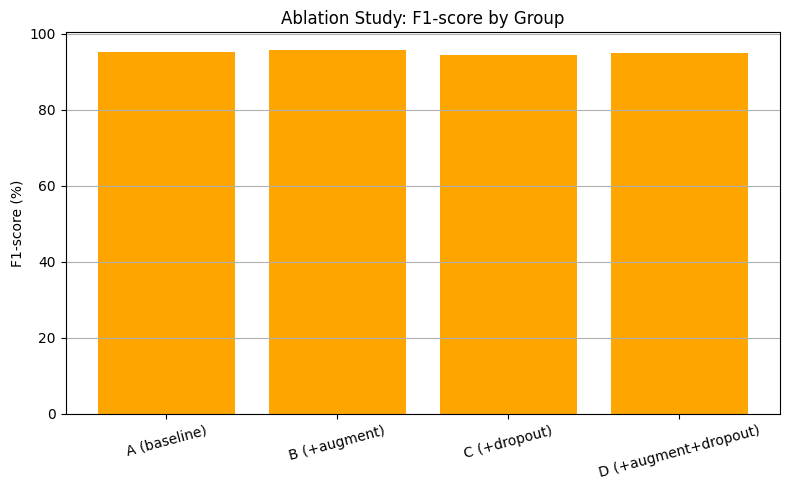

,Group,Accuracy,Precision,Recall,F1-score
0,A (baseline),94.364583,95.155718,95.125000,95.096938
1,B (+augment),93.645833,95.656178,95.583333,95.570180
2,C (+dropout),92.906250,94.511371,94.458333,94.406482
3,D (+augment+dropout),91.166667,94.885930,94.833333,94.823330


In [10]:
# visualization
results_df = pd.DataFrame(results, columns=["Group", "Accuracy", "Precision", "Recall", "F1-score"])

# show bar chart F1-score
plt.figure(figsize=(8, 5))
plt.bar(results_df["Group"], results_df["F1-score"], color='orange')
plt.title("Ablation Study: F1-score by Group")
plt.ylabel("F1-score (%)")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
display(results_df)
